# Pricing
### 1/26/2017

## Problem Statement
Company XYZ sells a software for $39. Since revenue has been flat for some time, the VP of Product has decided to run a test increasing the price. She hopes that this would increase revenue. In the experiment, 66 percent of the users have seen the old price (39), while a random sample of 33% users a higher price (59). The test has been running for some time and the VP of Product is interested in understanding how it went and whether it would make sense to increase the price for all the users.  


Especially he asked you the following questions:  
--Should the company sell its software for 39 or 59?  
--The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main findings looking at the data?  
--[Bonus] The VP of Product feels that the test has been running for too long and he should have been able to get statistically significant results in a shorter time. Do you agree with her intuition? After how many days you would have stopped the test? Please, explain why.

## Part 0 - Setup, Import, Exploration

Before any complex analysis, let's perform some exploratory analysis and sanity checks to ensure our data makes sense.

In [1]:
# setup and import
## basics
import pandas as pd
import numpy as np
from pandas import DataFrame, Series

## date manipulation
from dateutil.parser import parse

## plotting
import matplotlib.pyplot as plt
%pylab inline

## formulas
import patsy

Populating the interactive namespace from numpy and matplotlib


In [2]:
# import data
results = pd.read_csv('test_results.csv')
users = pd.read_csv('user_table.csv')

In [3]:
# let's look at the first few rows
results.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [4]:
# let's look at the first few rows
users.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


Before diving into analysis, we should take a look at the data and perform a few checks for quality. This includes checking for missing values, examinig data types, and looking at the distribution of different variables to ensure nothing strange is happening.

In [5]:
# First, let's check for missing values
### define a function to check for missing values in a dataframe
def fillprc(dff):
    fillprc = [] # initialize empty list to be returned later
    dfcols = list(dff.columns.values) # get list of all column names
    for i in dfcols: # loop through each column and get percentage filled, defined as ratio of lengths
        colname = i
        collfillprc = float(dff[i].value_counts().sum())/dff[i].value_counts(dropna=False).sum()
    
        fillprc.append((colname,collfillprc)) # add tuple of colname and percentage filled to list
     
    missinglist = [f for f in fillprc if f[1] != 1] # Filter fillprc list for less than 100%

    return missinglist

In [6]:
# check for missing data in results
fillprc(results)
# great!

[]

In [7]:
# check for missing data in users
fillprc(users)
# great! we have some very complete data

[]

In [8]:
# now, let's look at the data types to see if anything needs to be converted
results.dtypes
# looks ok!

user_id              int64
timestamp           object
source              object
device              object
operative_system    object
test                 int64
price                int64
converted            int64
dtype: object

In [9]:
users.dtypes
# again, looks fine

user_id      int64
city        object
country     object
lat        float64
long       float64
dtype: object

In [10]:
# let's see if we have one row per user in both tables
len(set(users['user_id'])), len(users) # this compares how many unique users we have to how many rows in the table
# they should be equal and they are!

(275616, 275616)

In [11]:
len(set(results['user_id'])), len(results) # this compares how many unique users we have to how many rows in the table
# they should be equal and they are!

(316800, 316800)

Immediately we recognize that the list of results has about 40k more observations (and unique users) than the user information table. This means there are some users for which we do not have information about their location. This is a pretty significant percentage of our data, so we shouldn't necessarily drop these observations straight away. However, we will need to think about how to deal with this missing data, as well as try to understand if there is any systematic difference in the makeup of users who do and do not have additional location information. 

For now, let's combine all the data we have into one table by performing a left join of the results with the user information, merging on user id (which we have already established to be a unique identifier in both tables). A left join will suffice since this will exclude users that are only in the user table, which is fine since we don't have any information about their purchasing behavior.

In [12]:
# let's join the two tables together, and call this our 'main' data table
main = results.merge(users, how = 'left', left_on ='user_id', right_on='user_id')

# take a gander
main.head()
# looks as we would expect!

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


In [13]:
# let's confirm our hypothesis about missing data
fillprc(main)

[('city', 0.87), ('country', 0.87), ('lat', 0.87), ('long', 0.87)]

We see that only 87% of our results data has associated geographic information. Since we have a few hundred thousand rows, it's probably alright to exclude these users, but first we should see if we can find any differences in their traits that may bias our results by dropping them.

We will create a flag for missing this information, and then perform some simple crosstabs comparing the distribution of data for users with and without this additional data.

In [14]:
# create flag for extra data
main['hasgeo'] = main['country'].isnull() == False

In [15]:
# how does conversion vary by these users?
geo_conv = pd.crosstab(main['hasgeo'],main['converted'])
geo_conv['convprc'] = geo_conv[1]/(1.0*geo_conv[0]+geo_conv[1])
geo_conv
# conversion is a little below 2% for both groups

converted,0,1,convprc
hasgeo,,,
False,40395,789,0.019158
True,270597,5019,0.018210


In [16]:
# Let's test for independence of these two variables using a chi-squared test
from scipy.stats import chi2_contingency
chi2_contingency((pd.crosstab(main['hasgeo'],main['converted'])), correction=False)[1]  
# the 2nd item in this object is the p-value)

0.1811124650765159

In [17]:
# how does test prc vary by these users?
geo_test = pd.crosstab(main['hasgeo'],main['test'])
geo_test['testprc'] = geo_test[1]/(1.0*geo_test[0]+geo_test[1])
geo_test
# test percentage is around 36% for both groups

test,0,1,testprc
hasgeo,,,
False,26299,14885,0.361427
True,176428,99188,0.359878


In [18]:
# Let's test for independence of these two variables using a chi-squared test
chi2_contingency((pd.crosstab(main['hasgeo'],main['test'])), correction=False)[1]  
# the 2nd item in this object is the p-value)

0.54125166833789651

At this point, we've established that users with and without geographic data were placed in the test group, and convert, at essentially the same rate based on a chi-squared test for independence that does not result in statistically significant p-values. So, we can conclude that users are not missing geographic information in a way that is systematically biased with regards to the price they saw or their conversion rate. As such, we can move ahead with just the subset of users that have geographic data.

Next, we will examine the distribution of our qualitative variables, as well as the timestamp, just to make sure nothing looks out of the ordinary. Then, we can move on to answering the questions posed with confidence that our dataset is relatively clean and without any major errors.

In [19]:
# drop null values from dataset
main = main.dropna()

In [44]:
# quick check - what is overall conversion rate?

ccheck = main['converted'].value_counts()
ccheck['convprc'] = ccheck[1]/(1.0*ccheck[0]+ccheck[1])
ccheck
# conversion is about 1.82% overall

0          270597.00000
1            5019.00000
convprc         0.01821
Name: converted, dtype: float64

In [20]:
# quick check - does the higher price actually affect conversion?

# how does conversion vary by these users?
test_conv = pd.crosstab(main['test'],main['converted'])
test_conv['convprc'] = test_conv[1]/(1.0*test_conv[0]+test_conv[1])
test_conv
# conversion is about half a percent lower for users who saw the higher price - ok, the laws of economics have not failed us!

converted,0,1,convprc
test,,,
0,172939,3489,0.019776
1,97658,1530,0.015425


In [21]:
# let's look at the source of the customer referral
main['source'].value_counts()
# we see that users come from four main families: direct, friend referral, ads, and SEO. let's create a slightly higher-level
# variable that captures these four categories

direct_traffic     52594
ads-google         51576
ads_facebook       46365
ads_other          26084
seo-google         20157
ads-bing           19887
seo_facebook       18473
friend_referral    18011
seo-other           8058
ads-yahoo           6576
seo-yahoo           5961
seo-bing            1874
Name: source, dtype: int64

In [22]:
# import regex package to do a fancy split
import re

# define secondary source column as the first element when the source column is split on either - or _
main['source_2'] = main['source'].map(lambda x: re.split(pattern='[_-]',string=x)[0])

# check value counts
main['source_2'].value_counts()
#correct!

ads       150488
seo        54523
direct     52594
friend     18011
Name: source_2, dtype: int64

In [23]:
# let's check device
main['device'].value_counts()
# pretty straightforward

mobile    162321
web       113295
Name: device, dtype: int64

In [24]:
main['operative_system'].value_counts()
# again, nothing out of the ordinary

windows    87721
iOS        82982
android    65305
mac        21831
other      14143
linux       3634
Name: operative_system, dtype: int64

In [25]:
# next, let's look at the date distribution just to be safe. first, import the package
from dateutil.parser import parse

# re-cast timestamp column as a date object
main['timestamp'] = main['timestamp'].map(lambda x: parse(str(x)))

ValueError: minute must be in 0..59

In [26]:
# We see above we have some datetimes that do not conform to the expected values. specifically, we have timestamps that have a 
# minute indicator of 60, when it should range from 0 - 59. to remedy this, we will roll back anywhere with a minute or second
# value equal to 60 to 59. this may marginally alter the distribution of dates, but not significantly. 
# at any rate, we will keep track of how many changes we make.

# define a function to fix the date
def fixdate(date):
    
    # check the last two characters - the number of seconds - and replace 60 with 59
    if str(date)[-2:] == '60':
        date = date[:-2]+'59'
    
    # check the characters that correspond to minutes and replace 60 with 59
    if str(date)[-5:-3] == '60':
        date = date[:-5]+'59'+date[-3:]
        
    return date

In [27]:
# apply the function to change the date field
main['date_fix'] = main['timestamp'].map(fixdate)

# create a quick boolean to check if date changed or not and check values
main['date_changed'] = main['timestamp'] == main['date_fix']
main['date_changed'].value_counts()
# only 9000 changes, this is fine

True     266656
False      8960
Name: date_changed, dtype: int64

In [28]:
# delete unncessary columns to save space
del main['date_changed']
del main['timestamp']

# re-cast timestamp column as a date object
main['date_fix'] = main['date_fix'].map(lambda x: parse(str(x)))

# grab just the day so we can look at users by day without worrying about time
main['just_date'] = main['date_fix'].map(lambda x: x.date())

In [29]:
# check value counts, and show them in date order
main['just_date'].value_counts().sort_index(ascending=True)
# this is a lot of dates - might be something to view graphically

2015-03-02    1386
2015-03-03    1309
2015-03-04    1217
2015-03-05    2439
2015-03-06    6252
2015-03-07    4919
2015-03-08    3967
2015-03-09    1276
2015-03-10    1333
2015-03-11    1238
2015-03-12    2505
2015-03-13    6181
2015-03-14    5040
2015-03-15    3508
2015-03-16    1202
2015-03-17    1346
2015-03-18    1263
2015-03-19    2475
2015-03-20    6315
2015-03-21    5083
2015-03-22    3648
2015-03-23    1293
2015-03-24    1258
2015-03-25    1400
2015-03-26    2532
2015-03-27    6066
2015-03-28    4935
2015-03-29    3763
2015-03-30    1313
2015-03-31    1163
              ... 
2015-05-02    4786
2015-05-03    3761
2015-05-04    1308
2015-05-05    1402
2015-05-06    1246
2015-05-07    2502
2015-05-08    6130
2015-05-09    5105
2015-05-10    3770
2015-05-11    1245
2015-05-12    1292
2015-05-13    1268
2015-05-14    2403
2015-05-15    6276
2015-05-16    4832
2015-05-17    3705
2015-05-18    1299
2015-05-19    1337
2015-05-20    1188
2015-05-21    2351
2015-05-22    5999
2015-05-23  

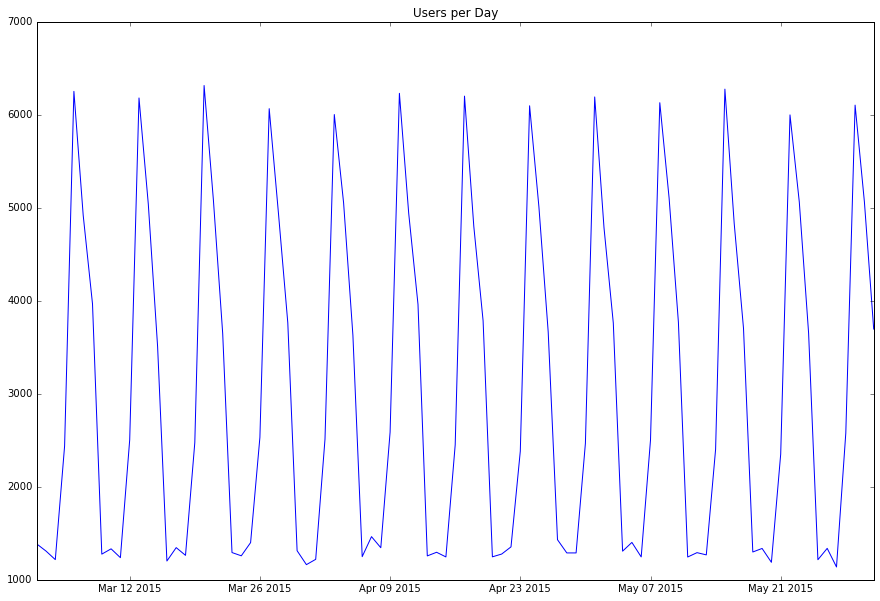

In [30]:
# let's create a line plot showing users per day
main['just_date'].value_counts().sort_index(ascending=True).plot(figsize=(15,10),title='Users per Day')
plt.show()

Clearly we some sort of weekly trend with repeating peaks and troughs. So, we will extract the weekday since it may be useful for later analysis.

In [31]:
# extract weekday and show value counts
main['weekday'] = main['date_fix'].map(lambda x: x.weekday())
main['weekday'].value_counts()

4    80047
5    64632
6    48512
3    32187
1    17104
0    16722
2    16412
Name: weekday, dtype: int64

In [32]:
# humans don't see weekdays as numbers - let's fix that!
import calendar

# create dictionary to replace day numbers with names
days=dict(enumerate(calendar.day_name))

# replace and show value counts
main['weekday'] = main['weekday'].replace(days)
main['weekday'].value_counts()

Friday       80047
Saturday     64632
Sunday       48512
Thursday     32187
Tuesday      17104
Monday       16722
Wednesday    16412
Name: weekday, dtype: int64

This is fascinating. We see a huge spike in traffic on weekends. This may come in handy later! 

In [33]:
# Let's take a quick look at conversion by day of week, just out of curiosity

# how does conversion vary by day?
day_conv = pd.crosstab(main['weekday'],main['converted'])
day_conv['convprc'] = day_conv[1]/(1.0*day_conv[0]+day_conv[1])
day_conv
# conversion isn't too different across days of the week - may still be useful

converted,0,1,convprc
weekday,,,
Friday,78557,1490,0.018614
Monday,16426,296,0.017701
Saturday,63463,1169,0.018087
Sunday,47605,907,0.018696
Thursday,31596,591,0.018361
Tuesday,16828,276,0.016137
Wednesday,16122,290,0.017670


## Part 1 - Pricing Decision
--Should the company sell its software for 39 or 59?

This is a question that can be answered in a lot of ways and depends on the company's strategic goals as well as a lot of other factors (competition, etc.) that cannot be inferred from this dataset. However, we will do our best to answer this question in a few different ways to give a variety of options to our corporate overlords. 

First, we will look at the goal of maximizing revenue, since that was the stated objective of the VP of Product was to increase revenue. Since we have different numbers of customers for users in the two pricing schemes, we will use the metric of revenue per customer to determine which is the better option. We can calculate that metric in both groups and come up with a conclusion. To take a more economic approach, we could run a regression to determine the elasticity of price and use those implications to make a recommendation about pricing strategy as well, however with only two price levels any conclusions would be only directionally informative. 

In [34]:
# create crosstab of user conversion by test grouping
revenue_simple = pd.crosstab(main['test'],main['converted'])

# calculate revenue as sales*price, scaling the test group's price up by (59/39)
revenue_simple['rev'] = revenue_simple[1]*39.0
revenue_simple['rev'][1] = revenue_simple['rev'][1]*(59.0/39.0)

# calculate revenue per customer
revenue_simple['rev_per_cust'] = revenue_simple['rev']/(1.0*revenue_simple[0]+revenue_simple[1])

# show it
revenue_simple

C:\Users\jzell\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


converted,0,1,rev,rev_per_cust
test,,,,
0,172939,3489,136071.0,0.771255
1,97658,1530,90270.0,0.910090


Taking the simplest view possible, we see that revenue per customer is around `$`.77 in the control group and `$`.91 per customer in the test group. This indicates that for the same number of customers, revenue in the test group would be higher. Put another way, the decrease in conversion is more than offset by the higher price paid by customers. This tells us that **demand is inelastic in this price range, so an increase in price will lead to an increase in revenue.** 

At this point, we could run a log-log regression predicting sales as a function of price, and we could interpret the coefficient on price as the elasticity of demand. However, we would really only have two data points - total sales for each of two prices (which would need to be corrected for sample size) - there isn't a lot more information to be gained here. Later, when we investigate factors related to conversion rate, we can draw more conclusions about pricing and elasticity. 

Next, let's suppose that the company's goal is maximizing profit. We know that profit is equal to revenue minus cost, but we do not know the cost. We can identify the breakeven cost at which point different pricing schemes make sense to maximize profit. The idea is that lower prices will result in more sales and potentially generate higher revenue, but the lower per-unit margin may result in lower profit. Conversely, higher prices mean fewer sales margin is higher, so profit may be higher. This doesn't really require any additional fancy code or modeling, just a few equations. The one missing piece is demand - we just need to create the number of sales per 1000 customers to keep it simple.

In [35]:
# create number of sales per 1000 customers for both pricing schemes
revenue_simple['sales_per_kcust'] = revenue_simple[1]*1.0/((revenue_simple[0]+revenue_simple[1])*1.0/1000)
revenue_simple

converted,0,1,rev,rev_per_cust,sales_per_kcust
test,,,,,
0,172939,3489,136071.0,0.771255,19.775773
1,97658,1530,90270.0,0.910090,15.425253


In a simplified economic model, profit is equal to quantity times margin. We will take our sales per 1000 customers, as well as profit margins, for both pricing schemes, and determine the breakeven price. Profit is defined below:

$$ \Pi = Q*(P-C) $$

For 1000 customers, and prices of `$`39 and `$`59, respectively, we get the following:
$$ \Pi = 19.78*(39-C) = 771.42 - 19.78*C $$
$$ \Pi = 15.43*(59-C) = 910.37 - 15.43*C $$

We can see here that the higher price option results in higher overall revenue, plus a lower cost regardless of the actual value of C, so the higher price option will always yield higher profits. Taking it one step further, we can estimate a simple linear demand curve and determine the profit-maximizing price level as a function of our cost C. We can estimate demand as a function of the form:

$$ Q_{d}(P) = A - b*Price $$

We have two points that represent combinations of (P,Q) - (39,19.78) and (59,15.43). This allows us to solve a system of linear equations and get the following demand function:

$$ Q_{d}(P) = 28.26 - .2175*P $$

This lets us express profit as the following:

$$ \Pi = Q*(P-C) = (28.26 - .2175*P)(P - C) $$

We can derive this equation with respect to price, set it equal to zero, solve for the optimal price, and get the following:

$$ P_{max \Pi} = 64.96 + 2.29*C $$

This tells us that to maximize profit, we want to price at approximately `$`65 plus 2.29 times cost. Granted, this is far beyond either of the pricing schemes attempted and elasticity of demand is likely to change when we move too far beyond our given prices. **However, the implication is that we may have room to increase the price to even more than `$`59 and still see an increase in profits.**

A third view of how to price the software could involve customer acquisition. Suppose that the company wants to steal as many customers as possible from its competitor, even at a loss, knowing that it can recoup any losses with later sales of additional profits. In this case, then price should be set at a point that maximizes conversion rate (especially of individuals who are not currently customers). This dovetails nicely into the next stated goal of the VP of product. 

#### Part 2 - Conversion
--The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main findings looking at the data?

We have already shown that the higher priced customers have a lower conversion rate - approximately 1.5% vs. 2%. But other than price, a number of other factors may play a role in conversion rate. What we are dealing with here is a binary classification problem, and there are a number of different models we can use to understand what's going on here as well as attempt to predict customer behavior. However, given that our VP of Product wants to look at actionable insights that affect conversion rate, we want to focus on modeling techniques that allow for interpretability. Thus, complicated ensemble methods such as random forest may not be the most appropriate. Additionally, since we are aiming to develop actionable insights, the ability to predict which customers are likely or not likely to convert may be of value, so out-of-sample prediction is useful. Based on the above characteristics, the best approach is probably to start with a simple logistic regression predicting conversion and examine the coefficients and their significance, as well as out-of-sample predictive power. 

In [36]:
# let's look at our data again
main.head()

,user_id,source,device,operative_system,test,price,converted,city,country,lat,long,hasgeo,source_2,date_fix,just_date,weekday
0,604839,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86,True,ads,2015-05-08 03:38:34,2015-05-08,Friday
1,624057,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24,True,seo,2015-05-10 21:08:46,2015-05-10,Sunday
2,317970,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73,True,ads,2015-04-04 15:01:23,2015-04-04,Saturday
3,685636,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90,True,direct,2015-05-07 07:26:01,2015-05-07,Thursday
4,820854,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02,True,ads,2015-05-24 11:04:40,2015-05-24,Sunday


In [37]:
# import modeling packages
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import f_classif
import patsy

In [38]:
# as a first attempt, as well as a sanity check, let's run a quick regression predicting conversion based solely on test pricing

# define formula
model1 = 'converted ~ test'

# create x and y using patsy's dmatrices
y,x = patsy.dmatrices(model1,main,return_type='dataframe')

# specify model objects and fit
feat1 = f_classif(x, y)
fit1 = LogisticRegression()

fit1.fit(x,y)

# store coefficients, p-value, and significance at 1% level
r2 = DataFrame(data=fit1.coef_[0],index=x.columns.values,columns=['coefficient'])
r2['pval'] = feat1[1]
r2['sig'] = r2['pval'] <= .01

# show results
r2

C:\Users\jzell\Anaconda2\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jzell\Anaconda2\lib\site-packages\sklearn\feature_selection\univariate_selection.py:113: UserWarning: Features [0] are constant.
  UserWarning)


,coefficient,pval,sig
Intercept,-1.951414,NaN,False
test,-0.253208,2.423876e-16,True


We see above the coefficient associated with *test* is -.25, but this coefficient is the effect on the log-odds, which isn't very interpretable. If raise e to this power (e^-.25 = ~.77), we can see the effect on the odds ratio. The odds ratio of converting to not falls by .77 when test = 1, meaning that conversion is about 3/4 as likely when test = 1. This is perfectly in line with our conversion rates of around 2% and 1.5% for control and test groups, respectively. We pass the sanity check! 

Now, we can move on to some other logistic regressions to hopefully uncover more insight. We will also split the data into a training and testing set and check our models to see how well they can predict out-of-sample.

In [56]:
# import packages
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [57]:
# Let's run another regression including source, device, and OS

# define formula
model2 = 'converted ~ test + source + device + operative_system'

# create x and y using patsy's dmatrices
y,x = patsy.dmatrices(model2,main,return_type='dataframe')

# create test and train sets
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.33, random_state=47)


# specify model objects and fit
feat2 = f_classif(X_train, Y_train)
fit2 = LogisticRegression()

fit2.fit(X_train,Y_train)

# store coefficients, p-value, and signifiance at 1% level
r2 = DataFrame(data=fit2.coef_[0],index=X_train.columns.values,columns=['coefficient'])
r2['exp_coef'] = np.exp(r2['coefficient']) # store exponentiated coefficient for easier interpretation
r2['pval'] = feat2[1]
r2['sig'] = r2['pval'] <= .01

# show results
r2

,coefficient,exp_coef,pval,sig
Intercept,-2.245611,0.105863,NaN,False
source[T.ads-google],0.502659,1.653112,4.802047e-04,True
source[T.ads-yahoo],0.023748,1.024032,5.996622e-03,True
source[T.ads_facebook],0.568416,1.765468,1.312018e-07,True
source[T.ads_other],0.165451,1.179925,2.750825e-04,True
source[T.direct_traffic],-0.054843,0.946634,2.292500e-23,True
source[T.friend_referral],1.160763,3.192369,6.813354e-69,True
source[T.seo-bing],0.421610,1.524414,7.481536e-01,False
source[T.seo-google],0.360138,1.433527,7.450757e-01,False
source[T.seo-other],0.277488,1.319810,3.195713e-01,False


In [58]:
# store predictions and display confusion matrix
preds = fit2.predict(X_test)
confusion_matrix(Y_test,preds)

array([[89269,     0],
       [ 1685,     0]])

These results are less than encouraging. We know that we are facing a challenging classification problem when there is such significant class imbalance - overall conversion rate is only 1.82%, so a baseline accuracy of 98.18% can be achieved by simply predicting that nobody converts. Unfortunately, that is exactly what our model does, so in terms of predictive power, it is not good.

However, we can still learn some interesting things from the significance of the coefficients. We can see that ads, direct traffic, and friend referrals have significant coefficients, with generally positive effects on conversion rate (as shown by the exponentiated coefficient > 1, implying these variables increase the odds ratio) for ads, and a very positive effect for friend referral. Note that for the source variable, the base case is *ads-bing* and all numbers are relative to that. The base cases for device and OS are mobile and Android, respectively. We also see that Windows, iOS, and Mac users have stronger conversion rates, while Linux and other users do not (compared to Android). These are useful insights, and after running a few more models, we will discuss their implications in terms of actionable insights. 

Getting back to the poor predictive power of our model, this is likely a function of our model seeking to maximize accuracy. Let's take a look at the ROC curve that displays the tradeoff between sensitivity (true positive rate) and 1 - specificity (false positive rate) at different decision thresholds. These statistics are more useful than simple accuracy when class imbalance is an issue. Right now, our model is predicting every user to be the negative class (not convert), so it is capturing 100% of the true negatives with zero false positives - so our specificity is one and our false positive rate is zero, and our sensitivity is also zero because we have not idenified any true positives. If we adjust the decision threshold to allow for more positive predictions, we will begin to capture some of the true positives, but will also gain a few false positives. This is the relationship displayed in the ROC curve.

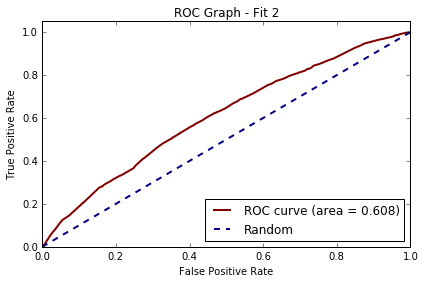

In [59]:
#### ROC Curve for Classifiers
from sklearn.metrics import (roc_curve, roc_auc_score)

fit2_probs = fit2.predict_proba(X_test)
fit2_probs = [item[1] for item in fit2_probs]

fpr, tpr, thresholds = roc_curve(Y_test, fit2_probs, pos_label=1)
lda_score = roc_auc_score(Y_test, fit2_probs)

plt.figure()
plt.plot(fpr, tpr, color='maroon',
         lw=2, label='ROC curve (area = %0.3f)' % lda_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph - Fit 2')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('chart.png')
plt.show()

This ROC curve is not pretty. The diagonal line represents the baseline, and the ideal point is in the upper left with 100% true positive rate and 0% false positives. This curve is showing that regardless of threshold, we aren't doing so well. 

However, at this point, we are concerned with actionable insights and uncovering factors that affect conversion. Let's try another interpretable classification model - the decision tree - that should show us another view of conversion rate. 

In [60]:
# import packages
from sklearn.tree import DecisionTreeClassifier

In [61]:
# let's fit a decision tree with the same formula as before
## Note - if we were really concerned with prediction, we could spend time on cross-validation and hyperparameter selection, 
## but we care more about determining which variables are important, so we don't need to worry about that for now. Furthermore,
## ensemble methods like random forests are better predictors, so they would be more appropriate for prediction, but not for
## interpretability.
tree1 = DecisionTreeClassifier()
tree1.fit(X_train,Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

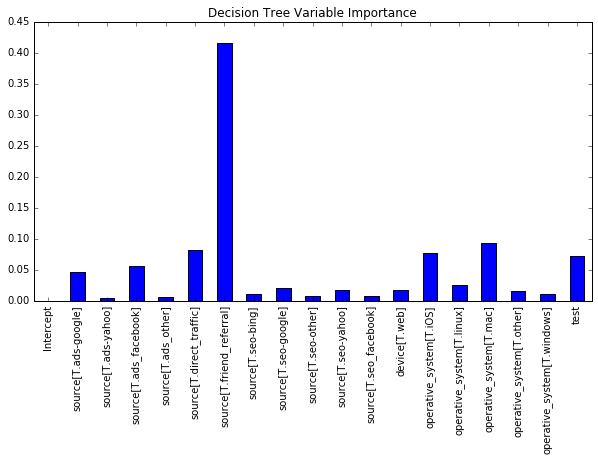

In [62]:
# let's view which variables are most important
treeimps = pd.DataFrame(index=X_train.columns,data=tree1.feature_importances_)
treeimps.plot(kind='bar',legend=False,title='Decision Tree Variable Importance',figsize=(10,5))

Our results above indicate that one variable contributes more than any other to reducing impurity in the decision tree - friend referral. This means that knowing if the source was a friend referral gives us more information about potential conversion than any other, a result that is backed up by the significant coefficient with a large value in the logistic regression. Direct traffic, iOS, and Mac users also convert differently than the general population, however it is important to note that this plot *does not* indicate the direction of the relationship. From above, we know that the exponentiated coefficient on *direct_traffic* is around .94, so direct traffic users are actually slightly less likely to convert than the base case of ads-bing. 

Next, let's run our model again with the bucketed sources to simplify things a bit.

In [63]:
# Let's run another regression including source_2, device, and OS

# define formula
model3 = 'converted ~ test + source_2 + device + operative_system'

# create x and y using patsy's dmatrices
y,x = patsy.dmatrices(model3,main,return_type='dataframe')

# create test and train sets
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.33, random_state=47)


# specify model objects and fit
feat3 = f_classif(X_train, Y_train)
fit3 = LogisticRegression()

fit3.fit(X_train,Y_train)

# store coefficients, p-value, and signifiance at 1% level
r2 = DataFrame(data=fit3.coef_[0],index=X_train.columns.values,columns=['coefficient'])
r2['exp_coef'] = np.exp(r2['coefficient']) # store exponentiated coefficient for easier interpretation
r2['pval'] = feat3[1]
r2['sig'] = r2['pval'] <= .01

# show results
r2

,coefficient,exp_coef,pval,sig
Intercept,-2.046711,0.129159,NaN,False
source_2[T.direct],-0.451547,0.636642,2.292500e-23,True
source_2[T.friend],0.763924,2.146683,6.813354e-69,True
source_2[T.seo],-0.087152,0.916538,4.044840e-02,False
device[T.web],-0.140778,0.868682,7.542814e-01,False
operative_system[T.iOS],0.377996,1.459357,4.099270e-15,True
operative_system[T.linux],-0.235425,0.790235,3.986879e-03,True
operative_system[T.mac],0.659990,1.934773,2.198872e-11,True
operative_system[T.other],-0.217056,0.804885,3.809043e-06,True
operative_system[T.windows],0.244677,1.277209,5.479421e-04,True


These results are more or less the same as before, although our coefficients have changed slightly. The base case for source is now all ads, and friend referrals still represent a major improvement over this, while direct traffic is even worse. SEO and ads appear to be comparable, as do web vs. mobile, as indicated by insignificant coefficients. Operating system results are generally the same - iOS, Mac, and Windows yield higher odds than Android. As before, the test variable is negative.

Let's take another look at the variable importances from a decision tree.

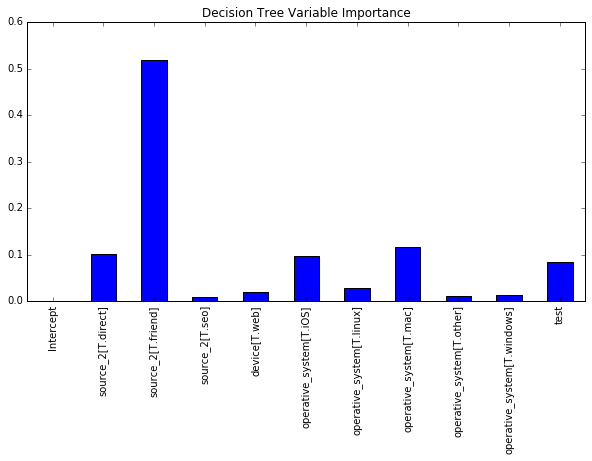

In [64]:
tree1 = DecisionTreeClassifier()
tree1.fit(X_train,Y_train)

# let's view which variables are most important
treeimps = pd.DataFrame(index=X_train.columns,data=tree1.feature_importances_)
treeimps.plot(kind='bar',legend=False,title='Decision Tree Variable Importance',figsize=(10,5))

We see more of the same.

As a final attempt, let's add a few more variables to the model. We will add weekday just for kicks, as well as try to think of some meaningful interaction terms. We know that friend referrals are important - but how important are they? Let's interact source_2 with test (which represents a higher price). The idea here is that users who received friend referrals may not only convert at a higher rate, but also be less sensitive to price changes. The same logic applies to operating system.

In [65]:
# Let's run another regression including source_2, device, and OS

# define formula
model4 = 'converted ~ test + source_2 + device + operative_system + weekday + test:source_2 + test:operative_system'

# create x and y using patsy's dmatrices
y,x = patsy.dmatrices(model4,main,return_type='dataframe')

# create test and train sets
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.33, random_state=47)


# specify model objects and fit
feat4 = f_classif(X_train, Y_train)
fit4 = LogisticRegression()

fit4.fit(X_train,Y_train)

# store coefficients, p-value, and signifiance at 1% level
r2 = DataFrame(data=fit4.coef_[0],index=X_train.columns.values,columns=['coefficient'])
r2['exp_coef'] = np.exp(r2['coefficient']) # store exponentiated coefficient for easier interpretation
r2['pval'] = feat4[1]
r2['sig'] = r2['pval'] <= .01

# show results
r2

,coefficient,exp_coef,pval,sig
Intercept,-2.048390,0.128942,NaN,False
source_2[T.direct],-0.447828,0.639015,2.292500e-23,True
source_2[T.friend],0.764728,2.148410,6.813354e-69,True
source_2[T.seo],-0.075821,0.926982,4.044840e-02,False
device[T.web],-0.040707,0.960110,7.542814e-01,False
operative_system[T.iOS],0.345499,1.412694,4.099270e-15,True
operative_system[T.linux],0.111488,1.117941,3.986879e-03,True
operative_system[T.mac],0.591087,1.805950,2.198872e-11,True
operative_system[T.other],-0.251426,0.777691,3.809043e-06,True
operative_system[T.windows],0.163718,1.177882,5.479421e-04,True


Here, we see that our original coefficients are all essentially unchanged excepting the major departure that is Linux. Now, Linux users are actually slightly more likely than Android users to convert. Scrolling past the insigificant weekday variables and the well-understood *test* variable, we arrive at our interaction terms. The first three that measure the effect of the test pricing specific to various sources are significant but all with odds ratio values close to 1, meaning their effect is not major. However, the test pricing interacted with operating system tells an interesting story with regards to the Linux OS. The odds ratio of conversion shrinks by nearly a factor of 10 for linux users who see the test pricing, and even combined with the positive effect of Linux alone, this still results in a major decrease in likelihood of conversion. This indicates that Linux users are much more price sensitive, so it is possible that these users have more readily available subistutes or value the product differently. None of the other OS variables interacted with *test* yield large swings in the odds of conversion.

Let's quickly see if this model is any better in terms of out-of-sample prediction (not likely), explore a few different prediciton thresholds, and then take a final look at variable importance from a decision tree using the same formula as above.

In [68]:
# store predictions and display confusion matrix
preds = fit4.predict(X_test)
confusion_matrix(Y_test,preds)

array([[89269,     0],
       [ 1685,     0]])

In [76]:
# store predicted probabilities
preds_prob = list(fit4.predict_proba(X_test))

# grab the second item (predicted probability for positive class)
preds_prob_pos = [x[1] for x in preds_prob]

In [79]:
# how does it look?
pd.Series(preds_prob_pos).describe()

count    90954.000000
mean         0.018067
std          0.007503
min          0.001053
25%          0.013041
50%          0.017131
75%          0.020842
max          0.061466
dtype: float64

In [85]:
# define a function to display metrics for classification
def get_cm_metrics(opt_cm):
    accuracy = (opt_cm[1][1]+opt_cm[0][0])*1.0/(opt_cm[1][0]+opt_cm[1][1]+opt_cm[0][0]+opt_cm[0][1])
    sensitivity = (opt_cm[1][1])*1.0/(opt_cm[1][0]+opt_cm[1][1])
    specificity = (opt_cm[0][0])*1.0/(opt_cm[0][1]+opt_cm[0][0])
    precision = (opt_cm[1][1])*1.0/(opt_cm[0][1]+opt_cm[1][1])
    print "Accuracy: %0.3f" % accuracy
    print "Sensitivity: %0.3f" % sensitivity
    print "Specificity: %0.3f" % specificity
    print "Precision: %0.3f" % precision

In [87]:
# try different thresholds in the range of predicted probabilities
thresholds = [.01, .015, .02, .025, .03, .035, .04, .045, .05]

# for thresholds, do the following:
for i in thresholds:
    preds_test = pd.Series(preds_prob_pos) > i # predict positive class if pred_prob > threshold
    print i # print threshold
    get_cm_metrics(confusion_matrix(Y_test,preds_test)) #print the conf matrix metrics for that threshold

0.01
Accuracy: 0.075
Sensitivity: 0.979
Specificity: 0.058
Precision: 0.019
0.015
Accuracy: 0.388
Sensitivity: 0.733
Specificity: 0.382
Precision: 0.022
0.02
Accuracy: 0.706
Sensitivity: 0.418
Specificity: 0.712
Precision: 0.027
0.025
Accuracy: 0.886
Sensitivity: 0.178
Specificity: 0.900
Precision: 0.032
0.03
Accuracy: 0.935
Sensitivity: 0.112
Specificity: 0.951
Precision: 0.041
0.035
Accuracy: 0.944
Sensitivity: 0.090
Specificity: 0.961
Precision: 0.041
0.04
Accuracy: 0.956
Sensitivity: 0.063
Specificity: 0.973
Precision: 0.042
0.045
Accuracy: 0.967
Sensitivity: 0.037
Specificity: 0.984
Precision: 0.043
0.05
Accuracy: 0.976
Sensitivity: 0.011
Specificity: 0.994
Precision: 0.037


Above we can see the tradeoff in true positive and false positive rate for varying thresholds. For example, when we take any user with a predicted conversion probability of .02 as positive, we are able to predict over 40% of the true positives, but we also have quite a few false positives (precision, or TP/(TP+FP), is less than 3%. 

These varying thresholds represent different scenarios for the business. Users with high predicted probabilities of conversion could be selected for targeted ads or promotions, which would come at a cost, but also likely cause some of these customers to convert who wouldn't otherwise. Depending on the cost of reaching out to users, as well as the profits from acquired users, varying thresholds could be optimal. This decision requires the input of more business data as well as strategic discussion with sales and marketing teams, but is useful to think about.

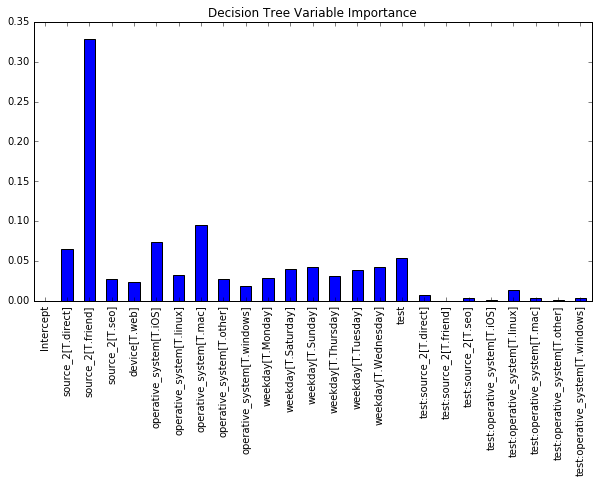

In [66]:
tree1 = DecisionTreeClassifier()
tree1.fit(X_train,Y_train)

# let's view which variables are most important
treeimps = pd.DataFrame(index=X_train.columns,data=tree1.feature_importances_)
treeimps.plot(kind='bar',legend=False,title='Decision Tree Variable Importance',figsize=(10,5))

In [69]:
# store predictions and display confusion matrix
preds = tree1.predict(X_test)
confusion_matrix(Y_test,preds)
# ugh...

array([[89269,     0],
       [ 1685,     0]])

#### Actionable Insights and Conclusions

After analyzing this data, we can draw a few conclusions, albeit with the caveat that our models were not realy able to accurately predict conversion. They include the following:  
  
**Pricing Decision** 
Based on economic analysis, we were able to show that demand is fairly inelastic between the prices of '$'39 and '$'59, so that both revenue per customer and profit per customer are higher at the higher price, regardless of product cost. This implies that if the goal is optimizing profit or revenue, then a price increase is a solid decision. However, this does not take into account the other consequences of increasing price, such as a change in market share or product perception. In addition to losing market share to competitors, if the product is known as a value product, then a price increase may fundamentally change how it's viewed and have unintended consequences. This requires input of marketing and sales resources, but based on the data available, the price increase is a good idea.
  
**Friend Referals**   
Friend referals, compared to other sources, make a given user significantly more likely to convert and purchase the product, regardless of pricing scheme. This implies that if the company can increase the percentage of traffic on the site that come from referrals, conversion rate can also likely be increased. Possible actions for this include referral bonuses in the form of product giveaways, rewards programs, etc. Additionally, identifying and working with influencers who can serve as product advocates for target demographics - such as a super user with a large community of friends who use similar products - will likely have value. 

**Operating System**
The data also showed that users across different operating systems are more or less likely to convert. Compared to the base case of Android, iOS, Mac, and Windows users all were more likely to convert, regardless of price. This could mean that the product is better suited for users on these platforms, or something about the demographics or preferences of these users makes them more inclined to purchase - they could be older and less tech-savvy, or seeking functionality different from what Android and Linux users are seeking. Possible recommendations include advertising specifically targeting Android users to bring their conversion rate up, or conversely, targetng iOS, Mac, and Windows users who may already be inclined to purchase. Another option would be to develop different product offerings targeting these different groups. Any of these decisions require business context beyond what is available in these data, such as product functionality, competitors, desired users, etc.

#### Bonus
The VP of Product feels that the test has been running for too long and he should have been able to get statistically significant results in a shorter time. Do you agree with her intuition? After how many days you would have stopped the test? Please, explain why.


This is a tricky question. As a general principle, results are better when sample size is larger, as the sample is more likely to be representative of the population as a whole, less likely to be sensitive to variations in the data, and is able to handle much more complex models with lower risk of overfitting. That being said, it is possible to obtain statistically significant results

If the measure we care about is response rate, and we want to establish a statistical significance between the difference in two groups, the apporpriate statistic is the following:

$$ Z=\dfrac{(\hat{p}_1-\hat{p}_2)-0}{\sqrt{\hat{p}(1-\hat{p})\left(\dfrac{1}{n_1}+\dfrac{1}{n_2}\right)}} $$

Where p-hat(1) and p-hat(2) are the sample proportions for the two groups, p-hat is the proportion for the group as a whole, and n1 and n2 are the sample sizes of the two groups. We want to find the minimum sample size at which our results would be significant, which requires making a few assumptions. Namely, we will assume the response rates in both groups are what we've observed - .0197 for test = 0, .0154 for test = 1, and .0182 overall. We will also assume the same 2/3 and 1/3 distribution for samples across the two groups, so we can substitute n2 = n1/2 to simplify the math. That yields the following:

$$ Z=\dfrac{.0197-.0154}{\sqrt{.0182(1-.0182)\left(\dfrac{1}{n_1}+\dfrac{2}{n_1}\right)}} $$

$$ Z=\dfrac{.0043}{\sqrt{.01786\left(\dfrac{3}{n_1}\right)}} $$

Now suppose we want z-score to equal 2.576, which would indicate significance at the 1% level, we can solve for sample size:

$$ 2.576=\dfrac{.0043}{\sqrt{.01786)\left(\dfrac{3}{n_1}\right)}} $$

$$ 2.576 * \sqrt{.01786\left(\dfrac{3}{n_1}\right)} = .0043 $$

$$ \sqrt{.01786\left(\dfrac{3}{n_1}\right)} = 0.001669 $$

$$ .01786\dfrac{3}{n_1} = 0.000002786 $$

$$ 6410.624 = \dfrac{3}{n_1} $$

$$ n_1 = ~2136 $$

This implies that to obtain a statistically significant sample at the 1% level, we need a little over 2000 people in group 1 and therefore a little over 1000 people in group 2 for a total of ~3300 people. This is a far cry from the hundreds of thousands in the data above. However, with a sample this small of internet users, there is significant risk for a biased sample, and the relatively low cost of adding users to the trial is another fact in favor of a larger sample size. Overall, the right answer is probably somewhere in the middle, between the bare minimum and what has been done. Users per day in the above data varies from around 1500 to 6000 users, and so a week of the experiment should yield plenty of data from which to draw accurate insights.